# **Análise Exploratória de Dados - Risco de Inadimplência de Crédito Residencial**

## Importando bibliotecas

In [1]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff

import os
import boto3
import botocore 
import sagemaker
import numpy as np
import pandas as pd 
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sagemaker import get_execution_role 
from sagemaker.image_uris import retrieve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## Lendo o conjunto de dados

In [2]:
bucket='credit2022rabelo'

In [3]:
role = get_execution_role() 

data_key_train = 'application_train.csv' 
data_location_train = 's3://{}/{}'.format(bucket, data_key_train) 

train = pd.read_csv(data_location_train) 
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train.shape

(307511, 122)

In [5]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:xlabel='TARGET', ylabel='count'>

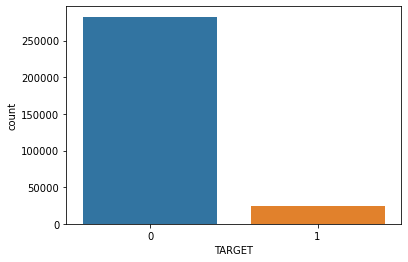

In [6]:
sns.countplot(x='TARGET',data=train)

A partir do gráfico acima observamos que este é um **problema de classe desequilibrado**. Há muito mais empréstimos que foram pagos no prazo do que empréstimos que não foram pagos.

In [7]:
role = get_execution_role() 

data_key_test = 'application_test.csv' 
data_location_test = 's3://{}/{}'.format(bucket, data_key_test) 

test = pd.read_csv(data_location_test) 
test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [8]:
test.shape

(48744, 121)

## Examinando valores ausentes

In [9]:
def missing_values_table(df):
        # Total de valores faltantes
        mis_val = df.isnull().sum()
        
        # Porcentagem de valores faltantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Fazendo uma tabela com valores faltantes
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Renomeando as colunas
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Classificando a tabela por porcentagem de falta decrescente
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Imprimindo frase com um reumo geral das informações de dados ausentes
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Retornar dataframe com informações ausentes
        return mis_val_table_ren_columns

In [10]:
# Missing values statistics
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


O reconhecimento de valores ausentes é uma importante ferramenta na análise de dados, principalmente quando o foco é a construção de modelos de aprendizado de máquina, pois a grande maioria desses modelos requer o preenchimento desses valores ausentes (esse preenchimento de daods ausentes é o que chamamos de imputação). Na sessão posterior de nossa análise de dados, nós iremos utilizar o XGBoost, que é um modelo que pode manipular valores ausentes sem necessidade de imputação, e iremos comparar os resultados com um modelo XGBoost que utilizou dados imputados a fim de avaliar os resultados obtidos nas duas situações.

## EDA (Exploratory Data Analysis)

A Análise Exploratória de Dados (EDA) é um análise em que calculamos estatísticas e criamos visualizações para encontrar tendências, anomalias, padrões ou relacionamentos nos dados. O objetivo da EDA é explorar o que nossos dados podem nos dizer. Geralmente começa com uma visão geral de alto nível e, em seguida, restringe-se a áreas específicas à medida que encontramos áreas intrigantes dos dados. As descobertas podem ser interessantes por si só, ou podem ser usadas para informar nossas escolhas de modelagem, ajudando-nos a decidir quais recursos usar.

In [11]:
# Verificando presença de alguma anomalia na coluna DAYS_EMPLOYED
train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

<AxesSubplot:xlabel='TARGET', ylabel='count'>

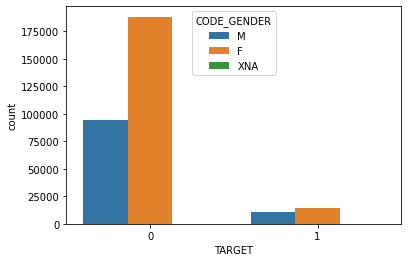

In [12]:
sns.countplot(x='TARGET',hue='CODE_GENDER',data=train)

<AxesSubplot:xlabel='TARGET', ylabel='FLAG_OWN_CAR'>

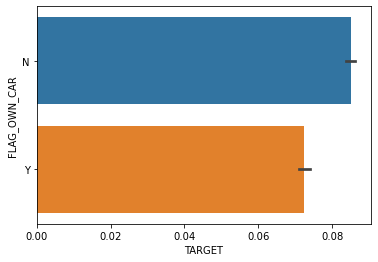

In [13]:
sns.barplot(x='TARGET',y='FLAG_OWN_CAR',data=train)

<AxesSubplot:xlabel='TARGET', ylabel='AMT_CREDIT'>

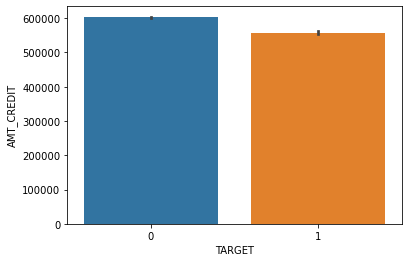

In [14]:
sns.barplot(x='TARGET',y='AMT_CREDIT',data=train)

<AxesSubplot:xlabel='TARGET', ylabel='AMT_INCOME_TOTAL'>

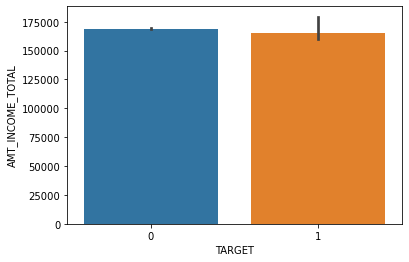

In [15]:
sns.barplot(x='TARGET',y='AMT_INCOME_TOTAL',data=train)

## Correlações entre as features

### Dados numéricos

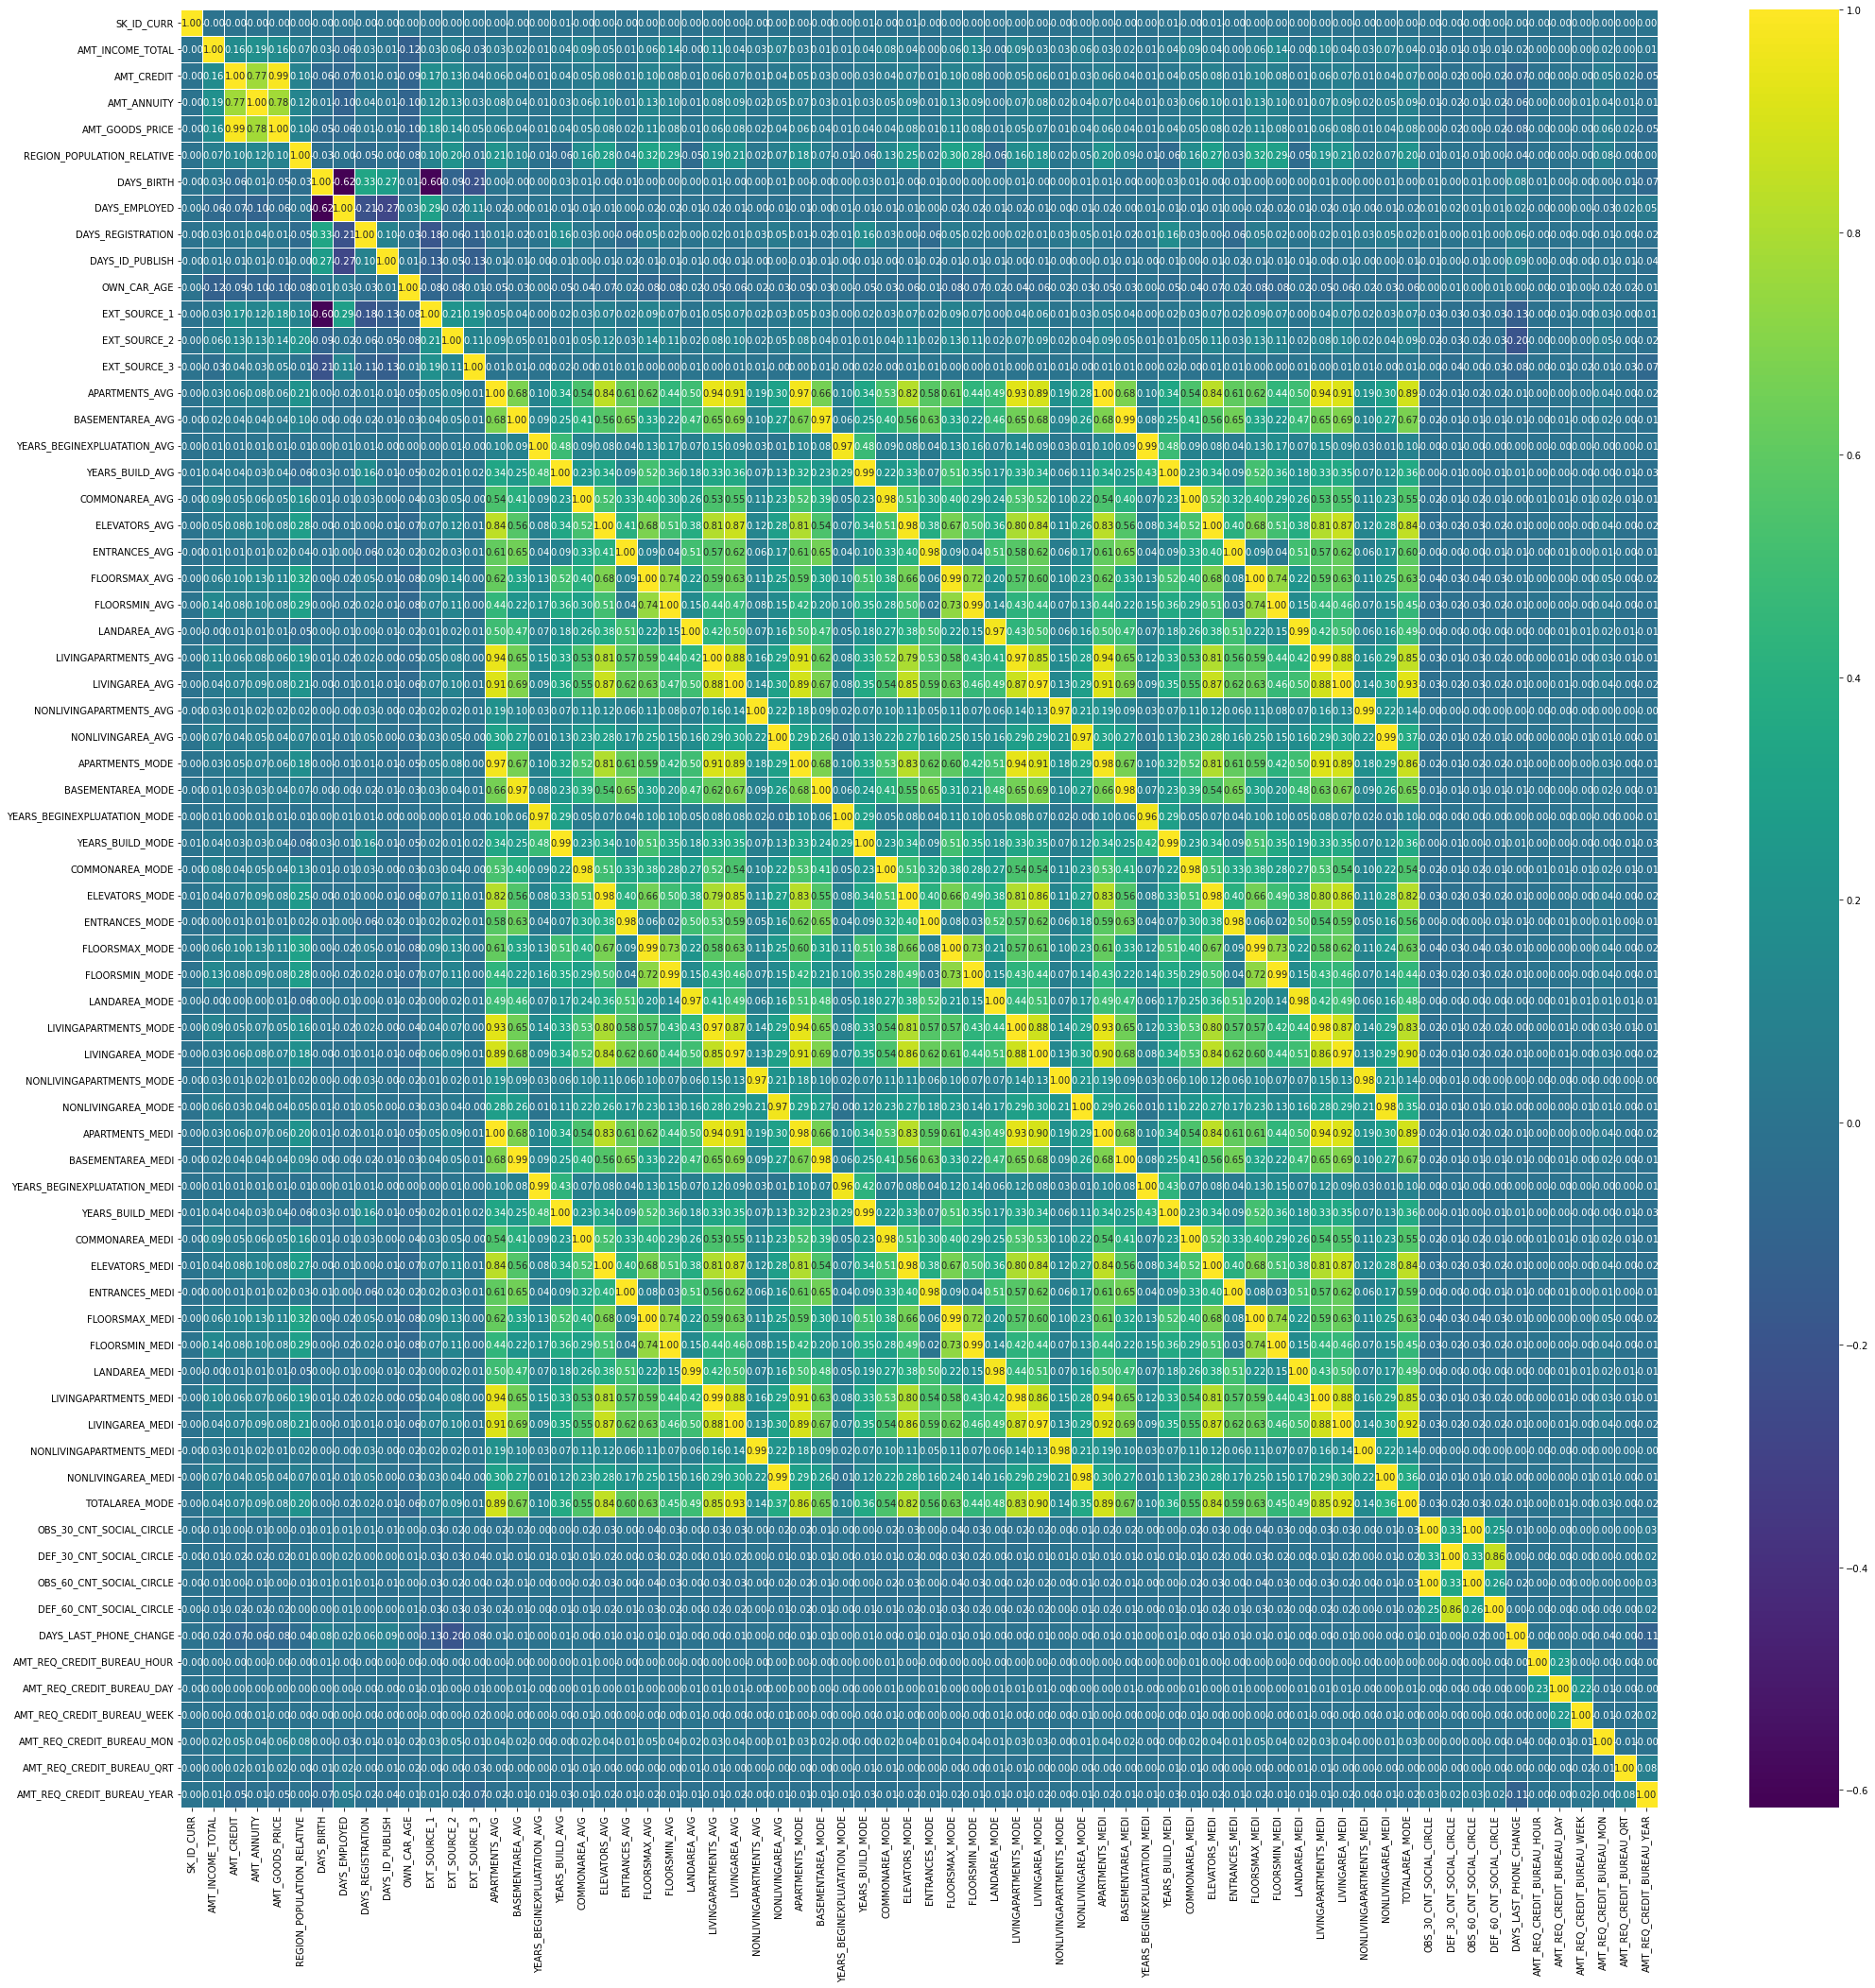

In [16]:
fig, ax= plt.subplots(figsize = (35,35))
sns.heatmap(train[["SK_ID_CURR","AMT_INCOME_TOTAL","AMT_CREDIT",
"AMT_ANNUITY","AMT_GOODS_PRICE","REGION_POPULATION_RELATIVE","DAYS_BIRTH",
"DAYS_EMPLOYED","DAYS_REGISTRATION","DAYS_ID_PUBLISH","OWN_CAR_AGE",
"EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3","APARTMENTS_AVG","BASEMENTAREA_AVG",
"YEARS_BEGINEXPLUATATION_AVG","YEARS_BUILD_AVG","COMMONAREA_AVG","ELEVATORS_AVG"
,"ENTRANCES_AVG","FLOORSMAX_AVG","FLOORSMIN_AVG","LANDAREA_AVG","LIVINGAPARTMENTS_AVG",
"LIVINGAREA_AVG","NONLIVINGAPARTMENTS_AVG","NONLIVINGAREA_AVG","APARTMENTS_MODE",
"BASEMENTAREA_MODE","YEARS_BEGINEXPLUATATION_MODE","YEARS_BUILD_MODE","COMMONAREA_MODE","ELEVATORS_MODE","ENTRANCES_MODE","FLOORSMAX_MODE","FLOORSMIN_MODE","LANDAREA_MODE",
"LIVINGAPARTMENTS_MODE","LIVINGAREA_MODE","NONLIVINGAPARTMENTS_MODE","NONLIVINGAREA_MODE",
"APARTMENTS_MEDI","BASEMENTAREA_MEDI","YEARS_BEGINEXPLUATATION_MEDI","YEARS_BUILD_MEDI",
"COMMONAREA_MEDI","ELEVATORS_MEDI","ENTRANCES_MEDI","FLOORSMAX_MEDI","FLOORSMIN_MEDI","LANDAREA_MEDI",
"LIVINGAPARTMENTS_MEDI","LIVINGAREA_MEDI","NONLIVINGAPARTMENTS_MEDI","NONLIVINGAREA_MEDI","TOTALAREA_MODE",
"OBS_30_CNT_SOCIAL_CIRCLE","DEF_30_CNT_SOCIAL_CIRCLE","OBS_60_CNT_SOCIAL_CIRCLE",
"DEF_60_CNT_SOCIAL_CIRCLE","DAYS_LAST_PHONE_CHANGE","AMT_REQ_CREDIT_BUREAU_HOUR",
"AMT_REQ_CREDIT_BUREAU_DAY","AMT_REQ_CREDIT_BUREAU_WEEK","AMT_REQ_CREDIT_BUREAU_MON",
"AMT_REQ_CREDIT_BUREAU_QRT","AMT_REQ_CREDIT_BUREAU_YEAR"]].corr(),cmap="viridis", annot = True, fmt = ".2f", linewidths=1, ax=ax)
plt.show()

### Dados categóricos

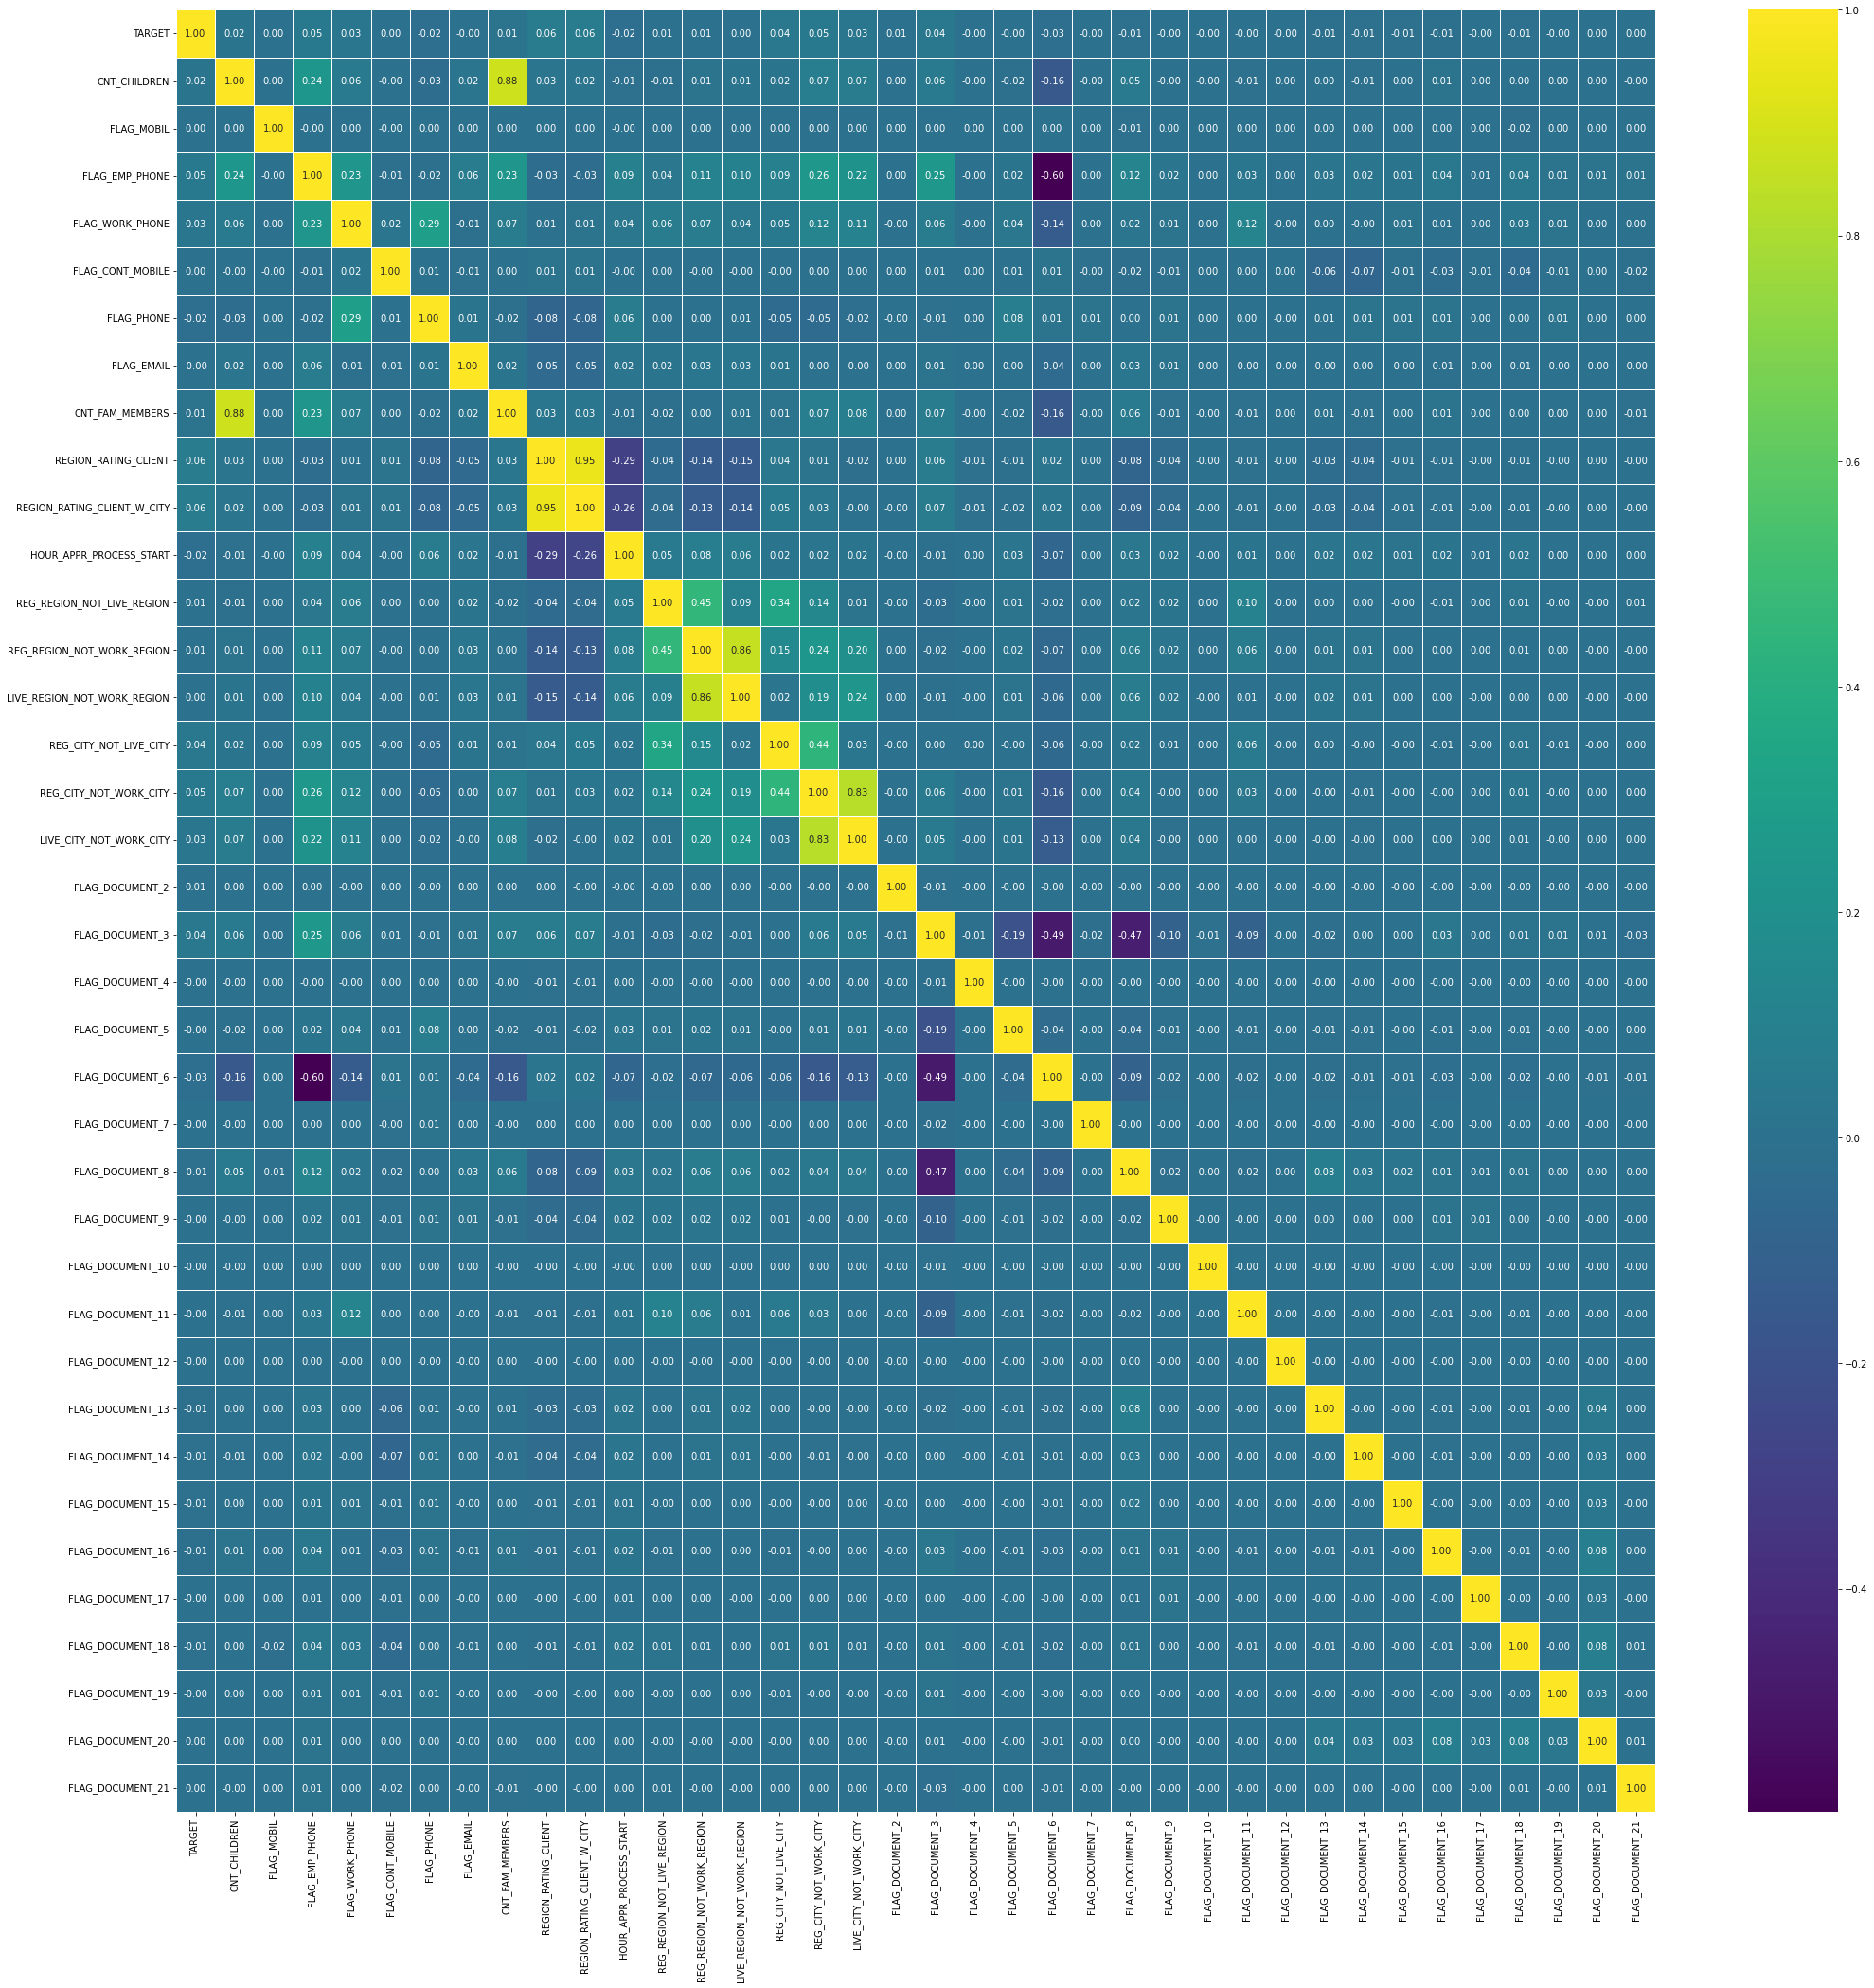

In [17]:
fig, ax= plt.subplots(figsize = (35,35))
sns.heatmap(train[["TARGET","NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY","CNT_CHILDREN",
"NAME_TYPE_SUITE","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS",
"NAME_HOUSING_TYPE","FLAG_MOBIL","FLAG_EMP_PHONE","FLAG_WORK_PHONE","FLAG_CONT_MOBILE",
"FLAG_PHONE","FLAG_EMAIL","OCCUPATION_TYPE","CNT_FAM_MEMBERS","REGION_RATING_CLIENT",
"REGION_RATING_CLIENT_W_CITY","WEEKDAY_APPR_PROCESS_START","HOUR_APPR_PROCESS_START",
"REG_REGION_NOT_LIVE_REGION","REG_REGION_NOT_WORK_REGION","LIVE_REGION_NOT_WORK_REGION",
"REG_CITY_NOT_LIVE_CITY","REG_CITY_NOT_WORK_CITY","LIVE_CITY_NOT_WORK_CITY",
"ORGANIZATION_TYPE","FONDKAPREMONT_MODE","HOUSETYPE_MODE","WALLSMATERIAL_MODE","EMERGENCYSTATE_MODE",
"FLAG_DOCUMENT_2","FLAG_DOCUMENT_3","FLAG_DOCUMENT_4","FLAG_DOCUMENT_5","FLAG_DOCUMENT_6",
"FLAG_DOCUMENT_7","FLAG_DOCUMENT_8","FLAG_DOCUMENT_9","FLAG_DOCUMENT_10","FLAG_DOCUMENT_11",
"FLAG_DOCUMENT_12","FLAG_DOCUMENT_13","FLAG_DOCUMENT_14","FLAG_DOCUMENT_15","FLAG_DOCUMENT_16",
"FLAG_DOCUMENT_17","FLAG_DOCUMENT_18","FLAG_DOCUMENT_19","FLAG_DOCUMENT_20","FLAG_DOCUMENT_21"]].corr(),cmap="viridis", annot = True, fmt = ".2f", linewidths=1, ax=ax)
plt.show()

# Remoção de dados altamente correlacionados

In [18]:
fcor= pd.DataFrame(train).corr()
cordf= fcor.where(np.triu(np.ones(fcor.shape), k = 1).astype(np.bool))
cordf = cordf.unstack().reset_index()
cordf.columns = ['var1', 'var2', 'Correlation']
cordf.dropna(subset = ['Correlation'], inplace = True)
mat = cordf.sort_values(by = 'Correlation', ascending = False)
maxc = mat[mat['Correlation'] > 0.8]
maxc

,var1,var2,Correlation
6713,YEARS_BUILD_MEDI,YEARS_BUILD_AVG,0.998495
8237,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,0.998490
7248,FLOORSMIN_MEDI,FLOORSMIN_AVG,0.997241
7141,FLOORSMAX_MEDI,FLOORSMAX_AVG,0.997034
7034,ENTRANCES_MEDI,ENTRANCES_AVG,0.996886
...,...,...,...
4489,LIVINGAPARTMENTS_AVG,ELEVATORS_AVG,0.811786
6932,ELEVATORS_MEDI,LIVINGAPARTMENTS_AVG,0.809331
6936,ELEVATORS_MEDI,APARTMENTS_MODE,0.808858
5987,LIVINGAPARTMENTS_MODE,ELEVATORS_MODE,0.807601


In [19]:
atrain = train.drop(["OBS_60_CNT_SOCIAL_CIRCLE","OBS_30_CNT_SOCIAL_CIRCLE",
"YEARS_BUILD_MEDI","FLOORSMIN_MEDI","FLOORSMAX_MEDI","ENTRANCES_MEDI","ELEVATORS_MEDI",
"COMMONAREA_MEDI","APARTMENTS_MEDI","BASEMENTAREA_MEDI","LIVINGAPARTMENTS_MEDI",
"NONLIVINGAPARTMENTS_MEDI","NONLIVINGAREA_MEDI","YEARS_BUILD_MODE",
"FLOORSMIN_MODE","FLOORSMAX_MODE","YEARS_BUILD_AVG","LANDAREA_MEDI",
"LIVINGAREA_MODE","YEARS_BEGINEXPLUATATION_MEDI"], axis = 1)

In [20]:
atest = test.drop(["OBS_60_CNT_SOCIAL_CIRCLE","OBS_30_CNT_SOCIAL_CIRCLE",
"YEARS_BUILD_MEDI","FLOORSMIN_MEDI","FLOORSMAX_MEDI","ENTRANCES_MEDI","ELEVATORS_MEDI",
"COMMONAREA_MEDI","APARTMENTS_MEDI","BASEMENTAREA_MEDI","LIVINGAPARTMENTS_MEDI",
"NONLIVINGAPARTMENTS_MEDI","NONLIVINGAREA_MEDI","YEARS_BUILD_MODE",
"FLOORSMIN_MODE","FLOORSMAX_MODE","YEARS_BUILD_AVG","LANDAREA_MEDI",
"LIVINGAREA_MODE","YEARS_BEGINEXPLUATATION_MEDI"], axis = 1)

In [21]:
atrain.shape

(307511, 102)

In [22]:
atest.shape

(48744, 101)

## Correlações entre a target e as features

### Target versus dados numéricos

In [23]:
corr = atrain.corr()['TARGET'].sort_values()
corr

EXT_SOURCE_3                  -0.178919
EXT_SOURCE_2                  -0.160472
EXT_SOURCE_1                  -0.155317
DAYS_EMPLOYED                 -0.044932
FLOORSMAX_AVG                 -0.044003
                                 ...   
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, Length: 86, dtype: float64

DAYS_BIRTH é a coluna que apresenta correlação mais alta com a TARGET. Essa feature é a idade em dias do cliente no momento do empréstimo em dias negativos (por qualquer motivo eles representaram assim?!?!). A correlação é positiva, mas o valor desta característica é realmente negativo, o que significa que, à medida que o cliente envelhece, é menos provável que deixe de pagar o empréstimo. 

Para melhorar a compreensão desse dado, primeiro, podemos fazer um histograma da idade onde iremos colocar o eixo x em anos para tornar o gráfico um pouco mais legível.

In [24]:
# Encontrando a correlação dos dias positivos 
train['DAYS_BIRTH'] = abs(train['DAYS_BIRTH'])
train['DAYS_BIRTH'].corr(train['TARGET'])

-0.07823930830982694

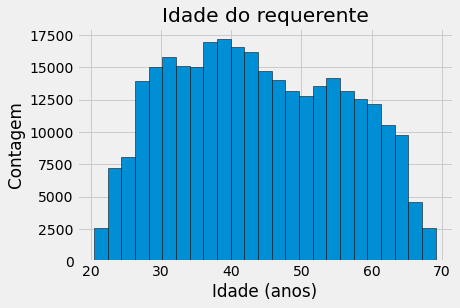

In [25]:
plt.style.use('fivethirtyeight')

# Traçando a distribuição de idade em anos
plt.hist(train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Idade do requerente'); plt.xlabel('Idade (anos)'); plt.ylabel('Contagem');

Por si só, a distribuição da idade não nos diz muito além de que não há discrepâncias, pois todas as idades são razoáveis. Para visualizar o efeito da idade no alvo {TARGET). Faremos a seguir um gráfico de estimativa de densidade do kernel (KDE) colorido pelo valor da TARGET. Um gráfico de estimativa de densidade do kernel mostra a distribuição de uma única variável e pode ser pensado como um histograma suavizado (é criado calculando um kernel, geralmente um gaussiano, em cada ponto de dados e, em seguida, calculando a média de todos os kernels individuais para desenvolver ums únics curva suavizada). 

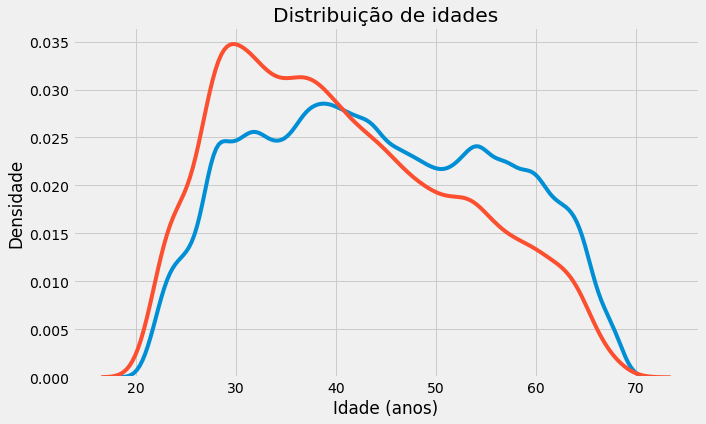

In [26]:
plt.figure(figsize = (10, 6))

# Emprestimos que foram pagos
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'Target == 0')

# Emprestimos que não foram pagos
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'Target == 1')

# Rotulagem
plt.xlabel('Idade (anos)'); plt.ylabel('Densidade'); plt.title('Distribuição de idades');

### Remoção de features com baixa correlação com a target (correlações entre -0,02 e 0,02)

In [27]:
a_train = atrain.drop(["FLOORSMIN_AVG","BASEMENTAREA_AVG","ENTRANCES_AVG","BASEMENTAREA_MODE",              
"LIVINGAPARTMENTS_MODE","LIVINGAPARTMENTS_AVG","ENTRANCES_MODE","AMT_ANNUITY","NONLIVINGAREA_AVG",              
"AMT_REQ_CREDIT_BUREAU_MON","FLAG_DOCUMENT_16","FLAG_DOCUMENT_13","NONLIVINGAREA_MODE",             
"YEARS_BEGINEXPLUATATION_AVG","COMMONAREA_AVG","FLAG_DOCUMENT_14","YEARS_BEGINEXPLUATATION_MODE",   
"COMMONAREA_MODE","FLAG_DOCUMENT_8","FLAG_DOCUMENT_18","LANDAREA_MODE","FLAG_DOCUMENT_15",
"FLAG_DOCUMENT_9","FLAG_DOCUMENT_11","AMT_INCOME_TOTAL","FLAG_DOCUMENT_17","FLAG_DOCUMENT_4",                
"AMT_REQ_CREDIT_BUREAU_QRT","LANDAREA_AVG","FLAG_EMAIL","NONLIVINGAPARTMENTS_AVG",        
"FLAG_DOCUMENT_7","FLAG_DOCUMENT_10","FLAG_DOCUMENT_19","NONLIVINGAPARTMENTS_MODE","FLAG_DOCUMENT_12",               
"FLAG_DOCUMENT_5","FLAG_DOCUMENT_20","FLAG_CONT_MOBILE","AMT_REQ_CREDIT_BUREAU_WEEK","FLAG_MOBIL",                     
"AMT_REQ_CREDIT_BUREAU_HOUR","AMT_REQ_CREDIT_BUREAU_DAY","LIVE_REGION_NOT_WORK_REGION",
"FLAG_DOCUMENT_21","LIVINGAREA_MEDI","FLAG_DOCUMENT_2","REG_REGION_NOT_LIVE_REGION","CNT_FAM_MEMBERS",
"AMT_REQ_CREDIT_BUREAU_YEAR","CNT_CHILDREN","ELEVATORS_AVG","FLOORSMAX_AVG","LIVINGAREA_AVG","WALLSMATERIAL_MODE",
                       "APARTMENTS_MODE","ELEVATORS_MODE","DEF_30_CNT_SOCIAL_CIRCLE","DEF_60_CNT_SOCIAL_CIRCLE"], axis = 1)

In [28]:
a_train.shape

(307511, 43)

In [29]:
a_test = atest.drop(["FLOORSMIN_AVG","BASEMENTAREA_AVG","ENTRANCES_AVG","BASEMENTAREA_MODE",              
"LIVINGAPARTMENTS_MODE","LIVINGAPARTMENTS_AVG","ENTRANCES_MODE","AMT_ANNUITY","NONLIVINGAREA_AVG",              
"AMT_REQ_CREDIT_BUREAU_MON","FLAG_DOCUMENT_16","FLAG_DOCUMENT_13","NONLIVINGAREA_MODE",             
"YEARS_BEGINEXPLUATATION_AVG","COMMONAREA_AVG","FLAG_DOCUMENT_14","YEARS_BEGINEXPLUATATION_MODE",   
"COMMONAREA_MODE","FLAG_DOCUMENT_8","FLAG_DOCUMENT_18","LANDAREA_MODE","FLAG_DOCUMENT_15",
"FLAG_DOCUMENT_9","FLAG_DOCUMENT_11","AMT_INCOME_TOTAL","FLAG_DOCUMENT_17","FLAG_DOCUMENT_4",                
"AMT_REQ_CREDIT_BUREAU_QRT","LANDAREA_AVG","FLAG_EMAIL","NONLIVINGAPARTMENTS_AVG",        
"FLAG_DOCUMENT_7","FLAG_DOCUMENT_10","FLAG_DOCUMENT_19","NONLIVINGAPARTMENTS_MODE","FLAG_DOCUMENT_12",               
"FLAG_DOCUMENT_5","FLAG_DOCUMENT_20","FLAG_CONT_MOBILE","AMT_REQ_CREDIT_BUREAU_WEEK","FLAG_MOBIL",                     
"AMT_REQ_CREDIT_BUREAU_HOUR","AMT_REQ_CREDIT_BUREAU_DAY","LIVE_REGION_NOT_WORK_REGION",
"FLAG_DOCUMENT_21","LIVINGAREA_MEDI","FLAG_DOCUMENT_2","REG_REGION_NOT_LIVE_REGION",      
"CNT_FAM_MEMBERS","AMT_REQ_CREDIT_BUREAU_YEAR","CNT_CHILDREN","ELEVATORS_AVG","FLOORSMAX_AVG","WALLSMATERIAL_MODE",
                     "LIVINGAREA_AVG","APARTMENTS_MODE","ELEVATORS_MODE","DEF_30_CNT_SOCIAL_CIRCLE",
                     "DEF_60_CNT_SOCIAL_CIRCLE"], axis = 1)

In [30]:
a_test.shape

(48744, 42)

## Analisando os tipos de dados presentes no dataframe

In [31]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

O número de colunas de cada tipo de dado (int64, float64 e object) é apresentado acima. int64 e float64 são variáveis numéricas (que podem ser discretas ou contínuas), euquanto colunas do tipo object contêm strings e são dados d tipo categóricos

In [32]:
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

A maioria das variáveis categóricas tem um número relativamente pequeno de entradas. Ainda assim, precisaremos lidar com essas entradas a fim de utilizar essas colunas em um modelo de machine learning. Dessa forma, utilizaremos **Label Encoding** (que é uma codificação de rótulos simples) e **one-hot encoding** que cria uma nova coluna para cada categoria exclusiva em uma variável categórica (Ou seja, cada observação origina uma coluna que receberá um 1 na coluna para sua categoria correspondente e um 0 em todas as outras novas colunas) para resolver essa questão.

No caso das colunas que possuem um número maior de entradas, o número de colunas criadas com a codificação one-hot poderia ser um problema ( a dimensão do conjunto de dados pode explodir nesses casos). Para lidar com isso, podemos executar a codificação one-hot seguida de PCA ou outros métodos de redução de dimensionalidade para reduzir o número de dimensões (enquanto ainda tentamos preservar as informações).

**Nota:** LightGBM é um modelo de machine learning que pode lidar variáveis categóricas (strings)

**Observação:** Para implementar o **Label Encoding** nós utilizaremos o **Scikit-Learn LabelEncoder** e para o **One-hot encoding** utilizaremos a função do Pandas denominda **get_dummies (df)**.

In [33]:
# Utilizando Label encoding
le = LabelEncoder()
le_count = 0

# Iterando nas colunas
for col in train:
    if train[col].dtype == 'object':
        # Se tiver duas categorias únicas ou menos:
        if len(list(train[col].unique())) <= 2:
            le.fit(train[col])
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            # Acompanhando quantas colunas foram codificadas por rótulo
            le_count += 1
            
print('%d colunas foram codificadas por rótulo.' % le_count)

3 colunas foram codificadas por rótulo.


In [34]:
# one-hot encoding of categorical variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)

print('Forma do conjunto de dados de treinamento: ', train.shape)
print('Forma do conjunto de dados de teste: ', test.shape)

Forma do conjunto de dados de treinamento:  (307511, 243)
Forma do conjunto de dados de teste:  (48744, 239)


## **Igualando número de colunas nos dataframes de treinamento e teste**

É necessário que haja as mesmas colunas nos dados de treinamento e teste. A codificação one-hot criou mais colunas nos dados de treinamento porque havia algumas variáveis categóricas com categorias não representadas nos dados de teste. Para remover as colunas nos dados de treinamento que não estão nos dados de teste, precisamos alinhar os dataframes. Primeiro, extraímos a coluna de destino dos dados de treinamento (porque isso não está nos dados de teste, mas precisamos manter essas informações). Quando fazemos o alinhamento, devemos nos certificar de definir axis = 1 para alinhar os dataframes com base nas colunas e não nas linhas!

In [35]:
train_labels = train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

# Add the target back in
train['TARGET'] = train_labels

print('Forma do conjunto de dados de treinamento: ', train.shape)
print('Forma do conjunto de dados de teste: ', test.shape)

Forma do conjunto de dados de treinamento:  (307511, 240)
Forma do conjunto de dados de teste:  (48744, 239)
